In [1]:
import numpy as np
from keras.layers import Input, Dense
from keras.models import Sequential, Model
from keras.backend import clear_session
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical
from os import getcwd
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [2]:
use_sample = False

In [3]:
DIR_NB = getcwd()
DIR_DATA = DIR_NB + '/data/CatDog'

if use_sample:
    DIR_TRAIN = DIR_DATA + '/sample/train'
    DIR_TEST = DIR_DATA + '/sample/test'
    DIR_VALID = DIR_DATA + '/sample/valid'
    DIR_RESULTS = DIR_DATA + '/sample/results'
else:
    DIR_TRAIN = DIR_DATA + '/train'
    DIR_TEST = DIR_DATA + '/test'
    DIR_VALID = DIR_DATA + '/valid'
    DIR_RESULTS = DIR_DATA + '/results'

In [4]:
clear_session()
vgg = VGG16(include_top=True)
vgg_output = vgg.layers[-2].output
x = Dense(2, activation='softmax')(vgg_output)
model = Model(vgg.input, x)
for layer in model.layers[:-1]:
    layer.trainable = False
    
model.compile(RMSprop(lr=0.1), 'categorical_crossentropy', ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
def vgg_preprocess(x):
    x = x[:, :, ::-1]
    # Zero-center by mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [6]:
generator = ImageDataGenerator(preprocessing_function=vgg_preprocess)
train_batches = generator.flow_from_directory(DIR_TRAIN, target_size=(224, 224), batch_size=64)
val_batches = generator.flow_from_directory(DIR_VALID, target_size=(224, 224), batch_size=64, shuffle=False)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [7]:
hist = model.fit_generator(train_batches, int(train_batches.samples / train_batches.batch_size), epochs=2, validation_data=val_batches, validation_steps=int(val_batches.samples / val_batches.batch_size), verbose=0, callbacks=[TQDMNotebookCallback()])

In [8]:
for layer in model.layers[-3:]:
    layer.trainable = True

In [9]:
model.optimizer.lr = 0.01
hist = model.fit_generator(train_batches, int(train_batches.samples / train_batches.batch_size), epochs=3, validation_data=val_batches, validation_steps=int(val_batches.samples / val_batches.batch_size), verbose=0, callbacks=[TQDMNotebookCallback()])

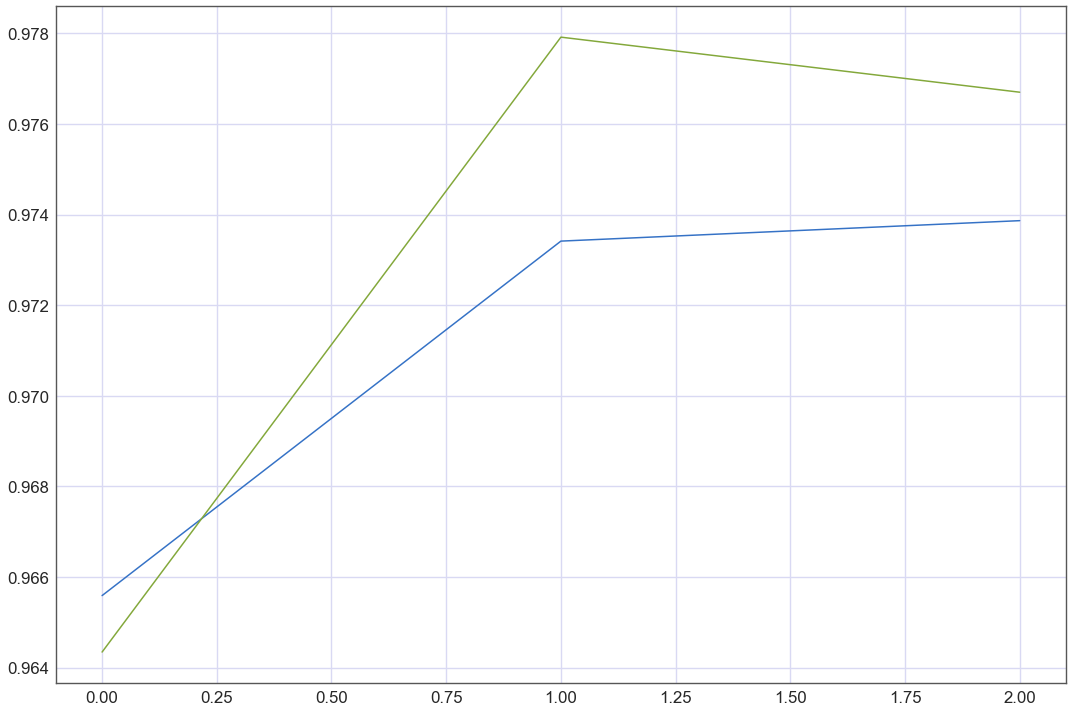

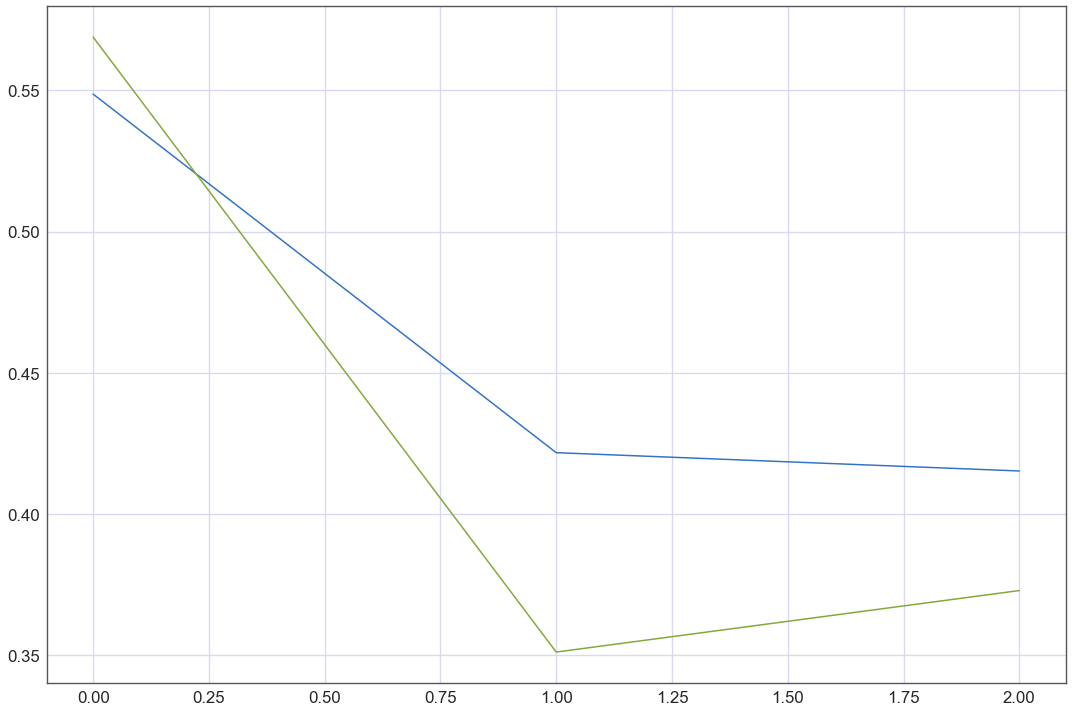

In [10]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [11]:
model.save_weights(DIR_RESULTS + '/weights.h5')

In [12]:
test_batches = generator.flow_from_directory(DIR_TEST, target_size=(224, 224), shuffle=False)

Found 12500 images belonging to 1 classes.


In [13]:
preds = model.predict_generator(test_batches, test_batches.samples / test_batches.batch_size, verbose=1)

391/390 [==============================] - 47s    


In [14]:
print(preds[:10])
test_batches.filenames[:10]

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]


['unknown/641.jpg',
 'unknown/1180.jpg',
 'unknown/5904.jpg',
 'unknown/10045.jpg',
 'unknown/405.jpg',
 'unknown/1903.jpg',
 'unknown/7860.jpg',
 'unknown/4276.jpg',
 'unknown/2428.jpg',
 'unknown/3102.jpg']

In [15]:
ids = np.stack([int(filename[filename.find('/')+1:filename.find('.')]) for filename in test_batches.filenames])

In [16]:
subm = np.stack([ids, preds[:, 1]], 1)

In [17]:
subm = subm[np.argsort(subm[:, 0])]

In [18]:
subm[:10]

array([[  1.,   1.],
       [  2.,   1.],
       [  3.,   1.],
       [  4.,   1.],
       [  5.,   0.],
       [  6.,   0.],
       [  7.,   0.],
       [  8.,   0.],
       [  9.,   0.],
       [ 10.,   0.]])

In [21]:
import csv

with open(DIR_RESULTS + '/submission.csv', mode='w') as f:
    writer = csv.writer(f)
    writer.writerow(('id', 'label'))
    for row in subm:
        writer.writerow((int(row[0]), np.clip(row[1], 0.02, 0.98)))